
# Model Building Jupyter Notebook
This Jupyter Notebook serves as the main file for constructing machine learning models and building appropriate feature sets. The notebook is organized into four key sections:

### 1. Data Pre-Processing
In this section, we will ensure the data is adequately processed for model building. We will:

- Assess the current state of data processing.

- Identify any additional features that need to be added to improve model efficiency.
### 2. Model Building
- Here, we will develop the initial models that will be trained on the data processed in the previous section. This section focuses on:

- Constructing the models without fine-tuning or interpretation at this stage.
### 3. Model Training and Evaluation
In this section, we will:

- Train the models using the prepared data.

- Evaluate the performance of each model.

- Determine if the model outputs are reliable and worth further consideration.
### 4. Results
The final section will involve analyzing the decision-making process of the models. We will:

- Examine the results of linear regression models.

- For more advanced algorithms, delve into both local and global interpretations to understand the decision-making of these "black box" models.


#### Setting up Enviornment 

In [1]:
import pandas as pd # This is to read csv files
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc # Classification Evaluation
from sklearn.linear_model import LogisticRegression # Logit Regression
import statsmodels.api as sm # For proper results interpretation of models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # Different type of scaling
from xgboost import XGBClassifier


# For LSTM Development 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt # General Plotting
import os 
import sys
import importlib
path = ('P:/6. DSMA/99. Thesis/Github/thesis')
os.chdir(path)

# Import the module
sys.path.append('P:/6. DSMA/99. Thesis/Github/thesis/scripts')
import pipeline_crypto_prices
from pipeline_crypto_prices import get_prices
import camel
import sentiment_analyzer
importlib.reload(pipeline_crypto_prices)
importlib.reload(camel)
importlib.reload(sentiment_analyzer)

<module 'sentiment_analyzer' from 'P:\\6. DSMA/99. Thesis/Github/thesis/scripts\\sentiment_analyzer.py'>

In [2]:
btc = pd.read_csv('data/processed/camel_v3_btc.csv').drop('Unnamed: 0', axis=1)
eth = pd.read_csv('data/processed/camel_v3_eth.csv').drop('Unnamed: 0', axis=1)
sol = pd.read_csv('data/processed/camel_v3_sol.csv').drop('Unnamed: 0', axis=1)

btc.index = pd.to_datetime(btc.Date)
eth.index = pd.to_datetime(eth.Date)
sol.index = pd.to_datetime(sol.Date)

print(btc.Date.min())
print(btc.Date.max())

btc = btc.drop(['Date', 'Close','ups','date','ATR_td', 'Dow_Returns', 'Dow_Volume', 'Oil_Returns', 'Oil_Volume','High','Low','unweighted_mean_sentiment'], axis=1)
eth = eth.drop(['Date', 'Close','ups','date','ATR_td', 'Dow_Returns', 'Dow_Volume', 'Oil_Returns', 'Oil_Volume','High','Low','unweighted_mean_sentiment'], axis=1)
sol = sol.drop(['Date', 'Close','ups','date','ATR_td', 'Dow_Returns', 'Dow_Volume', 'Oil_Returns', 'Oil_Volume','High', 'Low','unweighted_mean_sentiment'], axis=1)

btc.Indicator = np.where(btc.Indicator == 'Buy', 1, 0)
eth.Indicator = np.where(eth.Indicator == 'Buy', 1, 0)
sol.Indicator = np.where(sol.Indicator == 'Buy', 1, 0)

2024-02-03
2024-07-17


In [6]:
print(btc.columns)

Index(['Volume', 'Returns', 'MA_td', '3MA_td', '%K_td', '%D_td', 'RSI_td',
       'Momentum_td', 'MACD_td', 'CCI_td', 'BB_td', 'SNP_Returns',
       'SNP_Volume', 'Vix_Returns', 'Gold_Returns', 'Gold_Volume',
       'NVDA_Returns', 'NVDA_Volume', 'Total_WP', 'Total_Gtrends',
       'weighted_mean_sentiment', 'TVL', 'Indicator'],
      dtype='object')


#### Preparing the model dataset

##### Making lagged variables for non time series models 

In [4]:
no_lags = 3
btc_m, eth_m, sol_m = camel.thesis_lag(btc, num_lags = no_lags, target_column = ['Indicator','%K_td', '%D_td','RSI_td','MACD_td','CCI_td','BB_td','NVDA_Returns', 'NVDA_Volume']), camel.thesis_lag(eth, num_lags = no_lags, target_column = 'Indicator'), camel.thesis_lag(sol, num_lags = no_lags, target_column = 'Indicator')

##### Initializing Training and Test Datasets

In [7]:
btc_1, eth_1, sol_1 = btc_m, eth_m, sol_m


def prepare_data_and_calculate_vif(df, target_column='Indicator', split_ratio=0.8):
    # Get all column names except the target column
    columns = df.drop(columns=target_column).columns.tolist()

    # Select the columns for X and y
    X = df[columns]
    y = df[target_column]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert scaled features back to DataFrame to retain column names
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Split data into training and test sets while respecting the temporal order
    split_index = int(len(df) * split_ratio)
    X_train, X_test = X_scaled_df[:split_index], X_scaled_df[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
    vif["features"] = X_scaled_df.columns

    return X_train, X_test, y_train, y_test, vif

btc_x_train, btc_x_test, btc_y_train, btc_y_test, btc_vif = prepare_data_and_calculate_vif(btc_1)
eth_x_train, eth_x_test, eth_y_train, eth_y_test, eth_vif = prepare_data_and_calculate_vif(eth_1)
sol_x_train, sol_x_test, sol_y_train, sol_y_test, sol_vif = prepare_data_and_calculate_vif(sol_1)

In [137]:
evaluation = pd.DataFrame(
    columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'False Positive Rate', 'False Negative Rate']
)

#### Model 1: RandomForest Regression

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

def train_evaluate_random_forest(X_train, X_test, y_train, y_test, name, n_estimators=60, max_depth=10, min_samples_split=5, evaluation_df = evaluation):
    # Initialize and train the Random Forest model
    rfm = RandomForestClassifier(n_estimators=n_estimators, bootstrap=True, 
                                 max_depth=max_depth, min_samples_split=min_samples_split)
    rfm.fit(X_train, y_train)
    
    # Make predictions
    rf_pred = rfm.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, rf_pred)
    conf_matrix = confusion_matrix(y_test, rf_pred)
    class_report = classification_report(y_test, rf_pred)
    f1 = f1_score(y_test, rf_pred)
    recall = recall_score(y_test, rf_pred)
    precision = precision_score(y_test, rf_pred)
    # Get the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Calculate false positive rate
    false_positive_rate = fp / (fp + tn)
    # Calculate false negative rate
    false_negative_rate = fn / (fn + tp)
    
    # Print results
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)

   # Update or initialize the evaluation dataframe
    if evaluation_df is not None:
        model_key = f"{name}_RF_{n_estimators}_{max_depth}_{min_samples_split}"
        evaluation_df.loc[model_key] = ['Random Forest', accuracy, precision, recall, f1, specificity, false_positive_rate, false_negative_rate]
    
    
    # Return the model and predictions for further use if needed
    return rfm, rf_pred

btc_rfm, btc_rf_pred = train_evaluate_random_forest(btc_x_train, btc_x_test, btc_y_train, btc_y_test, 'BTC')
eth_rfm, eth_rf_pred = train_evaluate_random_forest(eth_x_train, eth_x_test, eth_y_train, eth_y_test, 'ETH')
sol_rfm, sol_rf_pred = train_evaluate_random_forest(sol_x_train, sol_x_test, sol_y_train, sol_y_test, 'SOL')

Accuracy: 0.6060606060606061
Confusion Matrix:
[[ 9  9]
 [ 4 11]]
Accuracy: 0.5454545454545454
Confusion Matrix:
[[ 7 11]
 [ 4 11]]
Accuracy: 0.6666666666666666
Confusion Matrix:
[[11  2]
 [ 9 11]]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [176]:
evaluation

,Model,Accuracy,Precision,Recall,F1 Score,Specificity,False Positive Rate,False Negative Rate
BTC_RF_60_10_5,Random Forest,0.606061,0.550000,0.733333,0.628571,0.500000,0.500000,0.266667
ETH_RF_60_10_5,Random Forest,0.545455,0.500000,0.733333,0.594595,0.388889,0.611111,0.266667
SOL_RF_60_10_5,Random Forest,0.666667,0.846154,0.550000,0.666667,0.846154,0.153846,0.450000
BTC_RF_C_8__kernal_sigmoid_gamme_auto,SVM,0.575758,0.526316,0.666667,0.588235,0.500000,0.500000,0.333333
ETH_RF_C_5__kernal_sigmoid_gamme_auto,SVM,0.636364,0.600000,0.600000,0.600000,0.666667,0.333333,0.400000
SOL_RF_C_4__kernal_sigmoid_gamme_auto,SVM,0.636364,0.750000,0.600000,0.666667,0.692308,0.307692,0.400000
BTC_XGB_2,XGBoost,0.575758,0.533333,0.533333,0.533333,0.611111,0.388889,0.466667
ETH_XGB_2,XGBoost,0.545455,0.500000,0.666667,0.571429,0.444444,0.555556,0.333333
SOL_XGB_2,XGBoost,0.757576,0.928571,0.650000,0.764706,0.923077,0.076923,0.350000
BTC_HMM_5,HMM,0.575758,0.571429,0.266667,0.363636,0.833333,0.166667,0.733333


ROC Curve to test model evaluation

###### The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a classification model. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity) across various threshold settings. The curve illustrates the trade-off between sensitivity and specificity: as one increases, the other may decrease. The area under the curve (AUC) provides a single scalar value to summarize the model's ability to distinguish between the positive and negative classes, with an AUC of 1 indicating perfect classification and an AUC of 0.5 suggesting no better than random chance. Thus, the ROC curve and AUC are valuable tools for assessing and comparing the discriminatory power of different classifiers.

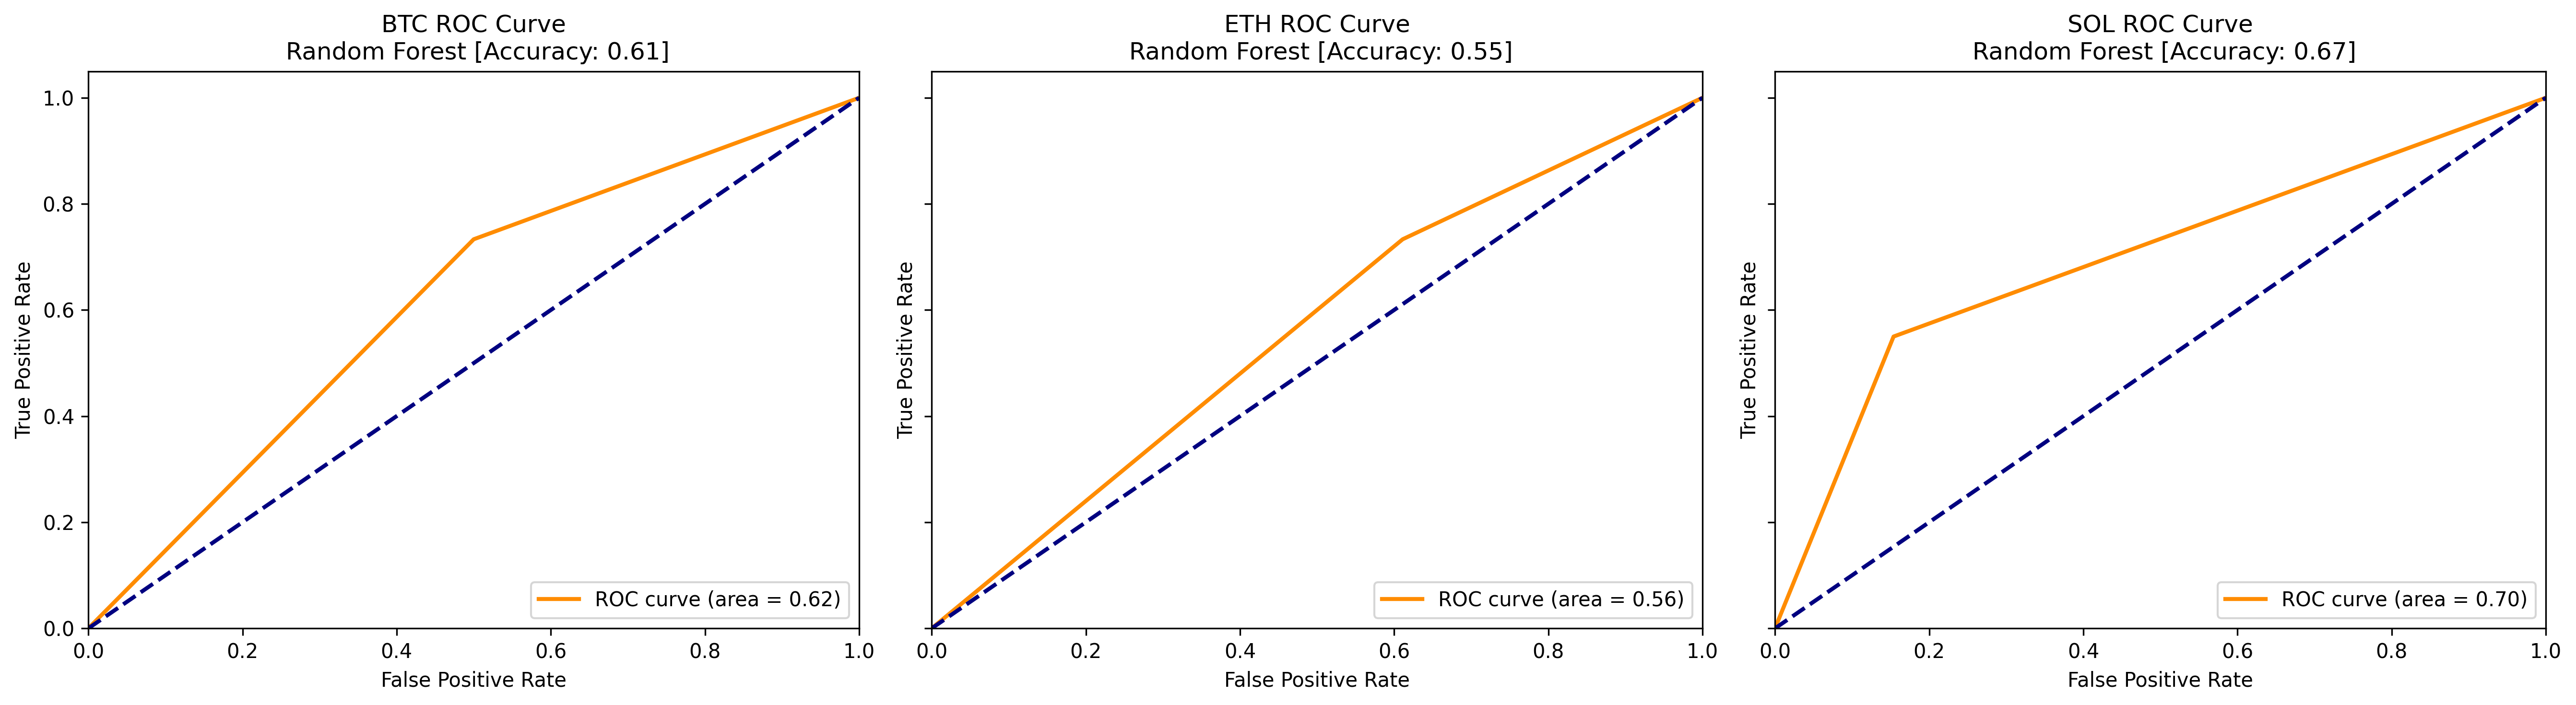

In [177]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_pred, crypto_name, model_name, ax):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_pred)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{crypto_name} ROC Curve\n {model_name} [Accuracy: {accuracy:.2f}]')
    ax.legend(loc="lower right")

# List of cryptocurrencies and their corresponding data
cryptos = [
    ('BTC', btc_y_test, btc_rf_pred, 'Random Forest'),
    ('ETH', eth_y_test, eth_rf_pred, 'Random Forest'),
    ('SOL', sol_y_test, sol_rf_pred, 'Random Forest')
]

# Create a figure with subplots for each cryptocurrency
n_cryptos = len(cryptos)
fig, axes = plt.subplots(1, n_cryptos, figsize=(6*n_cryptos, 5), dpi=300, sharey=True)

# Loop through the cryptocurrencies and plot their ROC curves
for (crypto_name, y_test, rf_pred, model_name), ax in zip(cryptos, axes):
    plot_roc_curve(y_test, rf_pred, crypto_name, model_name, ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()



#### Model 2: Support Vector Machine (SVM)

In [178]:
from sklearn.svm import SVC

def train_evaluate_support_vector(X_train, X_test, y_train, y_test, name, C=7, probability=True, gamma='auto', kernel='sigmoid', evaluation_df=evaluation):
    # Initialize and train the Random Forest model
    svc = SVC(C = C, probability=True, gamma='auto', kernel='sigmoid')
    svc.fit(X_train, y_train)
    
    # Make predictions
    svm_pred = svc.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, svm_pred)
    conf_matrix = confusion_matrix(y_test, svm_pred)
    class_report = classification_report(y_test, svm_pred)
    precision = precision_score(y_test, svm_pred)
    recall = recall_score(y_test, svm_pred)
    f1 = f1_score(y_test, svm_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, svm_pred).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Calculate false positive rate
    false_positive_rate = fp / (fp + tn)
    # Calculate false negative rate
    false_negative_rate = fn / (fn + tp)
    
    # Print results
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)

   # Update or initialize the evaluation dataframe   # Update or initialize the evaluation dataframe
    if evaluation_df is not None:
        model_key = f"{name}_RF_C_{C}__kernal_{kernel}_gamme_{gamma}"
        evaluation_df.loc[model_key] = ['SVM', accuracy, precision, recall, f1, specificity, false_positive_rate, false_negative_rate]
    
    # Return the model and predictions for further use if needed
    return svc, svm_pred

btc_svc, btc_svm_pred = train_evaluate_support_vector(btc_x_train, btc_x_test, btc_y_train, btc_y_test, 'BTC', C=8)
eth_svc, eth_svm_pred = train_evaluate_support_vector(eth_x_train, eth_x_test, eth_y_train, eth_y_test, 'ETH', C=5)
sol_svc, sol_svm_pred = train_evaluate_support_vector(sol_x_train, sol_x_test, sol_y_train, sol_y_test, 'SOL', C=4)

Accuracy: 0.5757575757575758
Confusion Matrix:
[[ 9  9]
 [ 5 10]]
Accuracy: 0.6363636363636364
Confusion Matrix:
[[12  6]
 [ 6  9]]
Accuracy: 0.6363636363636364
Confusion Matrix:
[[ 9  4]
 [ 8 12]]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [148]:
evaluation

,Model,Accuracy,Precision,Recall,F1 Score,Specificity,False Positive Rate,False Negative Rate
BTC_RF_60_10_5,Random Forest,0.545455,0.500000,0.800000,0.615385,0.333333,0.666667,0.200000
ETH_RF_60_10_5,Random Forest,0.575758,0.523810,0.733333,0.611111,0.444444,0.555556,0.266667
SOL_RF_60_10_5,Random Forest,0.575758,0.687500,0.550000,0.611111,0.615385,0.384615,0.450000
BTC_RF_C_8__kernal_sigmoid_gamme_auto,SVM,0.575758,0.526316,0.666667,0.588235,0.444444,0.555556,0.200000
ETH_RF_C_5__kernal_sigmoid_gamme_auto,SVM,0.636364,0.600000,0.600000,0.600000,0.388889,0.611111,0.266667
SOL_RF_C_4__kernal_sigmoid_gamme_auto,SVM,0.636364,0.750000,0.600000,0.666667,0.461538,0.538462,0.250000


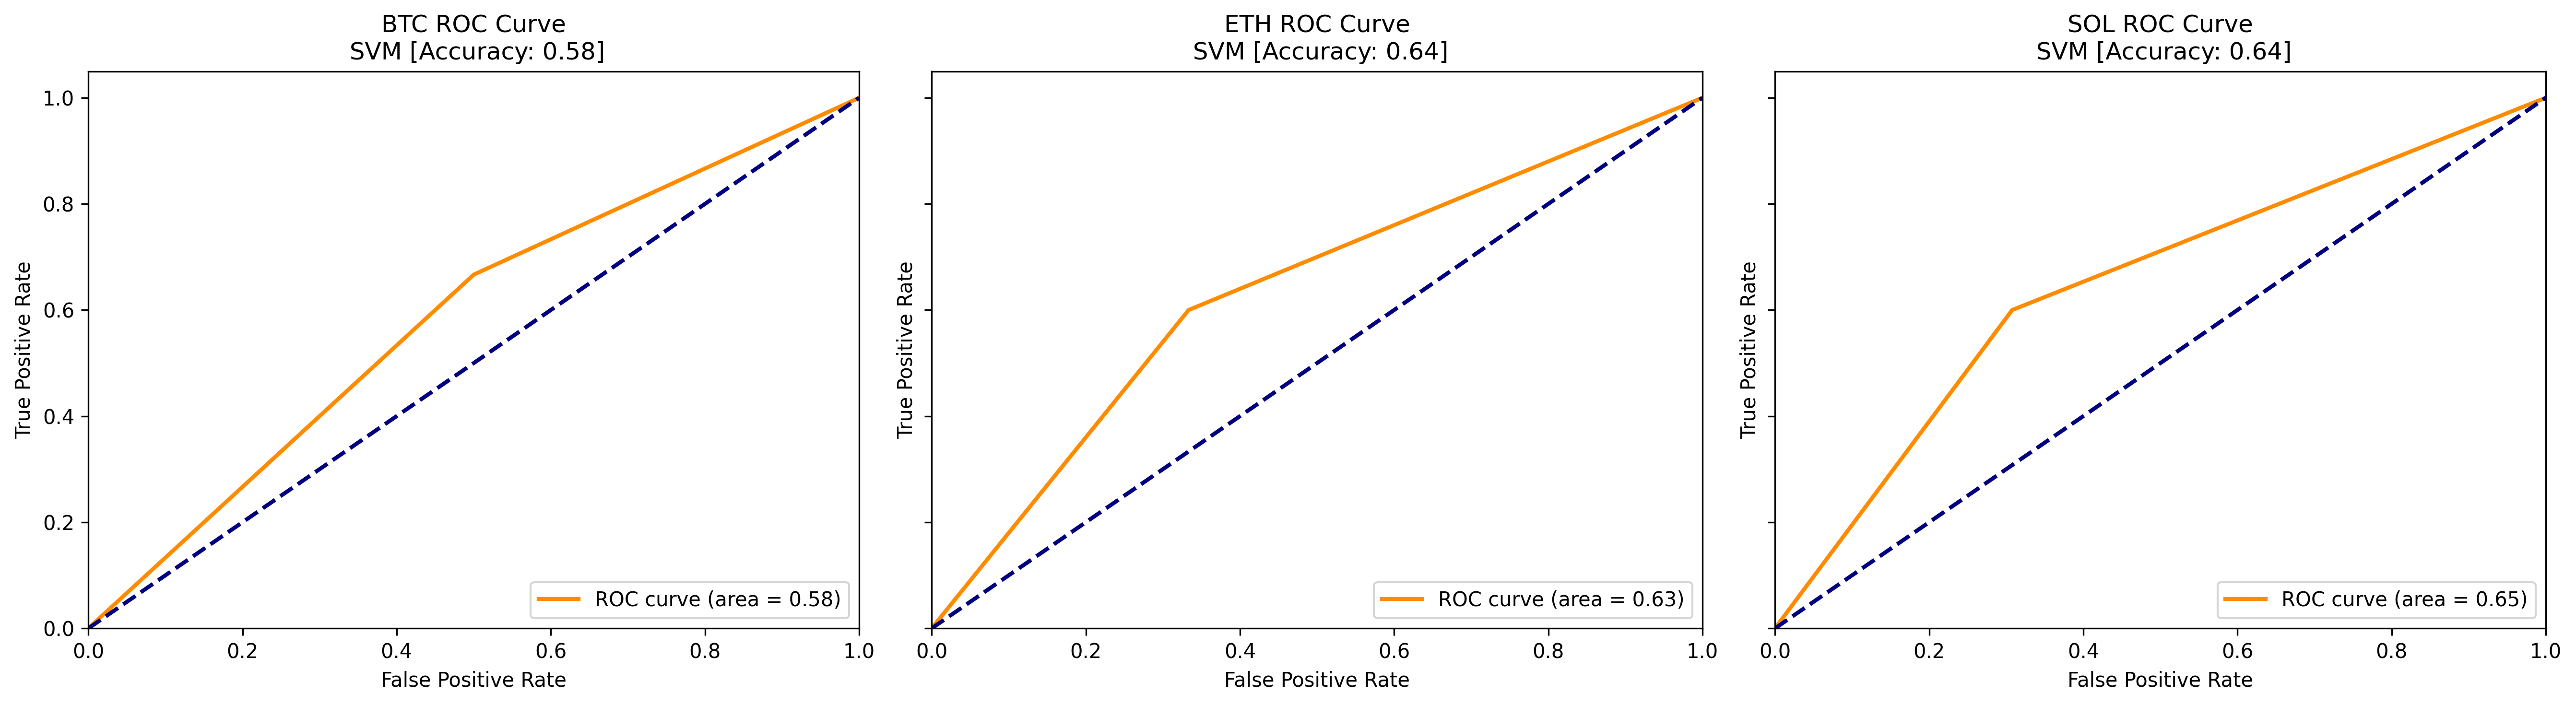

In [64]:
# List of cryptocurrencies and their corresponding data
cryptos = [
    ('BTC', btc_y_test, btc_svm_pred, 'SVM'),
    ('ETH', eth_y_test, eth_svm_pred, 'SVM'),
    ('SOL', sol_y_test, sol_svm_pred, 'SVM')
]
# Create a figure with subplots for each cryptocurrency
n_cryptos = len(cryptos)
fig, axes = plt.subplots(1, n_cryptos, figsize=(6*n_cryptos, 5), dpi=300, sharey=True)

# Loop through the cryptocurrencies and plot their ROC curves
for (crypto_name, y_test, rf_pred, model_name), ax in zip(cryptos, axes):
    plot_roc_curve(y_test, rf_pred, crypto_name, model_name, ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


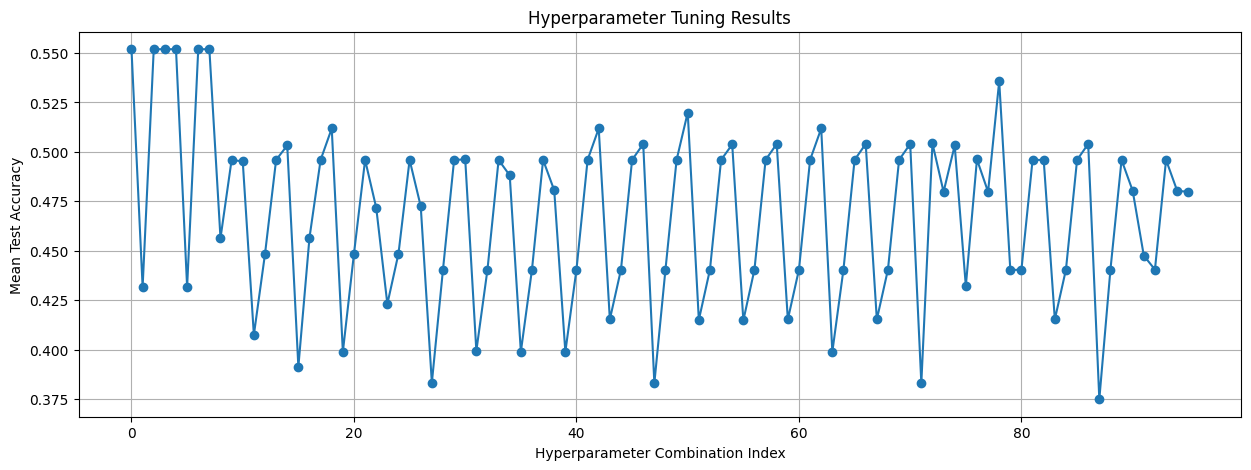

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.5519
Test Accuracy: 0.4062


In [361]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'C': [0.1, 2,3,4,5,6,7,8,9, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVC model
svc = SVC(probability=True)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1)

# Fit the model with training data
grid_search.fit(btc_x_train, btc_y_train)

# Get the results of the grid search
results = grid_search.cv_results_

# Extract relevant information
mean_test_scores = results['mean_test_score']
params = results['params']

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(range(len(mean_test_scores)), mean_test_scores, marker='o')
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Test Accuracy')
plt.grid(True)
plt.show()

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_
svm_pred = best_model.predict(btc_x_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(btc_y_test, svm_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


In [65]:
import shap 

# Create and fit the explainer
explainer = shap.Explainer(sol_svc.predict, sol_x_test)
shap_values = explainer(sol_x_test)

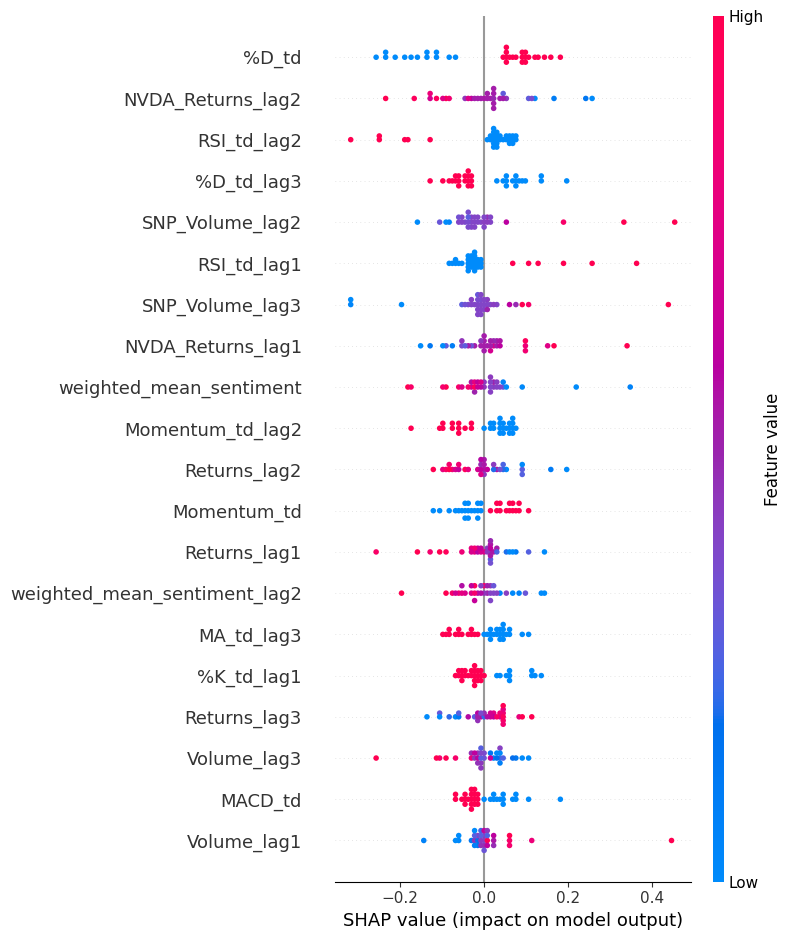

In [66]:
 shap.summary_plot(shap_values, sol_x_test, feature_names=sol_x_test.columns.tolist())

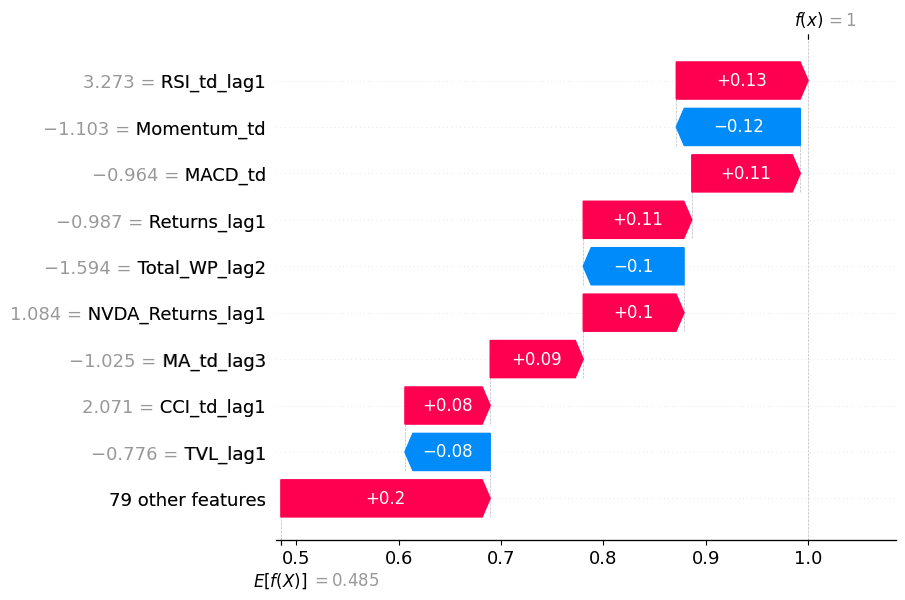

The actual value for the 12th instance is: 0


In [67]:
shap.waterfall_plot(shap_values[4])

# Show the plot
plt.show()

# Fetch the actual value for the 12th instance from y_test
actual_value = sol_y_test.iloc[4]  # Assuming y_test is a DataFrame or Series

print(f"The actual value for the 12th instance is: {actual_value}")

#### Model 3: GradientBoosting

In [167]:
import xgboost as xgb

# Create the DMatrix data format for XGBoost
btc_d_train = xgb.DMatrix(btc_x_train, label=btc_y_train)
btc_d_test = xgb.DMatrix(btc_x_test, label=btc_y_test)

eth_d_train = xgb.DMatrix(eth_x_train, label=eth_y_train)
eth_d_test = xgb.DMatrix(eth_x_test, label=eth_y_test)

sol_d_train = xgb.DMatrix(sol_x_train, label=sol_y_train)
sol_d_test = xgb.DMatrix(sol_x_test, label=sol_y_test)

# Set the parameters for the XGBoost model
btc_params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 6,                  # Maximum depth of a tree
    'eta': 1.2,                      # Learning rate
    'eval_metric': 'logloss' ,
    'lamda' : 4,
    'alpha' : 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma' : 2.7
                  # Evaluation metric
}

eth_params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 6,                  # Maximum depth of a tree
    'eta': 1.2,                      # Learning rate
    'eval_metric': 'logloss' ,
    'lamda' : 4,
    'alpha' : 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma' : 2.9
                  # Evaluation metric
}

sol_params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 6,                  # Maximum depth of a tree
    'eta': 1.2,                      # Learning rate
    'eval_metric': 'logloss' ,
    'lamda' : 4,
    'alpha' : 0.4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma' : 2.9
                  # Evaluation metric
}


def train_evaluate_xgboost(X_train, X_test, y_train, y_test, name, params=btc_params, evaluation_df=evaluation, num_rounds = 2):
    # Initialize and train the Random Forest model
    xgb = XGBClassifier(use_label_encoder=False, **params)
    xgb.fit(X_train, y_train)
    
    # Make predictions
    xgb_pred = xgb.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, xgb_pred)
    conf_matrix = confusion_matrix(y_test, xgb_pred)
    class_report = classification_report(y_test, xgb_pred)
    precision = precision_score(y_test, xgb_pred)
    recall = recall_score(y_test, xgb_pred)
    f1 = f1_score(y_test, xgb_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, xgb_pred).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Calculate false positive rate
    false_positive_rate = fp / (fp + tn)
    # Calculate false negative rate
    false_negative_rate = fn / (fn + tp)
    
    # Print results
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)

   # Update or initialize the evaluation dataframe   # Update or initialize the evaluation dataframe
    if evaluation_df is not None:
        model_key = f"{name}_XGB_{num_rounds}"
        evaluation_df.loc[model_key] = ['XGBoost', accuracy, precision, recall, f1, specificity, false_positive_rate, false_negative_rate]
    
    # Return the model and predictions for further use if needed
    return xgb, xgb_pred


btc_xgb, btc_xgb_pred = train_evaluate_xgboost(btc_x_train, btc_x_test, btc_y_train, btc_y_test, 'BTC', params=btc_params)
eth_xgb, eth_xgb_pred = train_evaluate_xgboost(eth_x_train, eth_x_test, eth_y_train, eth_y_test, 'ETH', params=eth_params)
sol_xgb, sol_xgb_pred = train_evaluate_xgboost(sol_x_train, sol_x_test, sol_y_train, sol_y_test, 'SOL', params=sol_params)

`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[18:32:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "lamda" } are not used.

Accuracy: 0.5757575757575758
Confusion Matrix:
[[11  7]
 [ 7  8]]
[18:32:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "lamda" } are not used.

Accuracy: 0.5454545454545454
Confusion Matrix:
[[ 8 10]
 [ 5 10]]
[18:32:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "lamda" } are not used.

Accuracy: 0.7575757575757576
Confusion Matrix:
[[12  1]
 [ 7 13]]


#### Model 4: XGBoost Tuning

In [134]:
explainer_xgb = shap.Explainer(sol_xgb.predict, sol_x_train)
shap_values = explainer(sol_x_train)

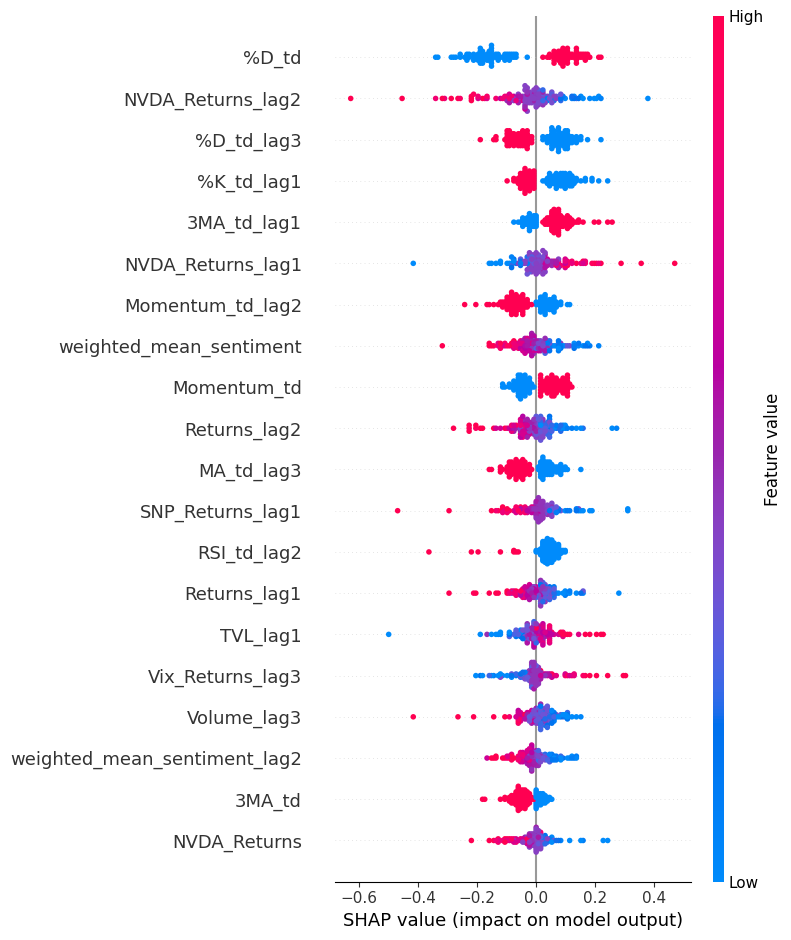

In [135]:
shap.summary_plot(shap_values, sol_x_train, feature_names=sol_x_train.columns.tolist())

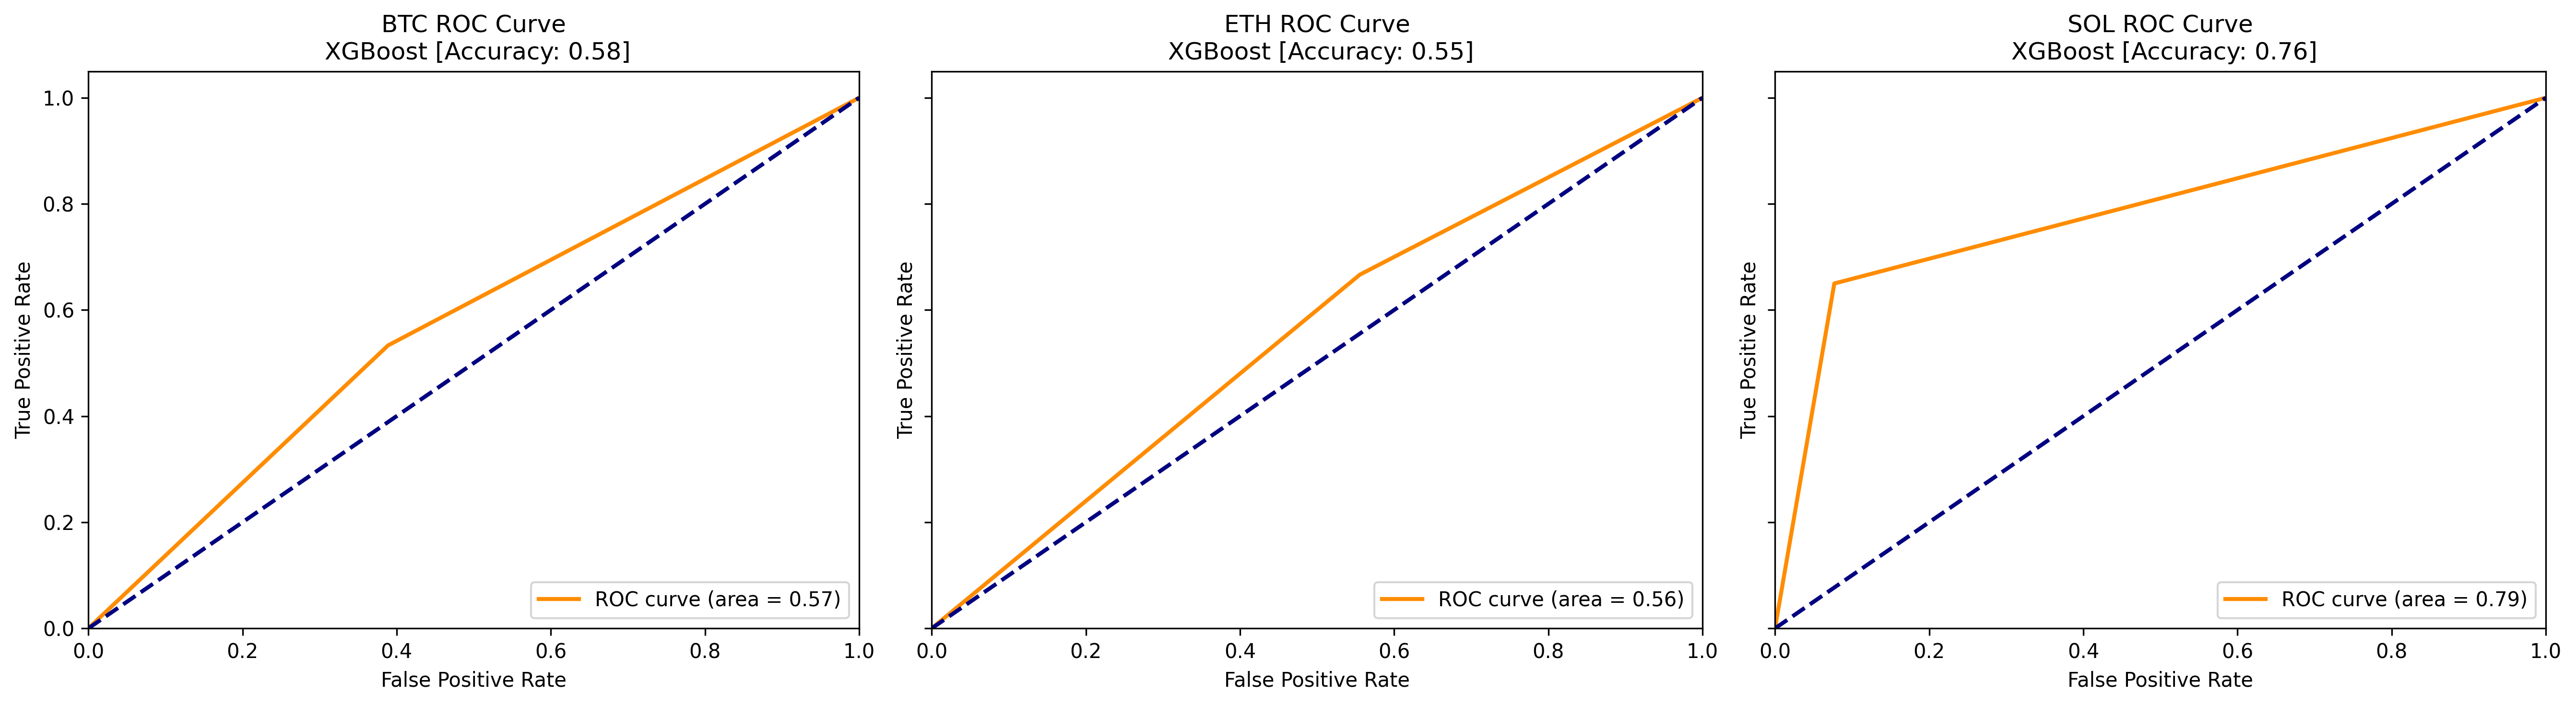

In [136]:
# List of cryptocurrencies and their corresponding data
cryptos = [
    ('BTC', btc_y_test, btc_xgb_pred, 'XGBoost'),
    ('ETH', eth_y_test, eth_xgb_pred, 'XGBoost'),
    ('SOL', sol_y_test, sol_xgb_pred, 'XGBoost'),
]
# Create a figure with subplots for each cryptocurrency
n_cryptos = len(cryptos)
fig, axes = plt.subplots(1, n_cryptos, figsize=(6*n_cryptos, 5), dpi=300, sharey=True)

# Loop through the cryptocurrencies and plot their ROC curves
for (crypto_name, y_test, btc_xgb_pred, model_name), ax in zip(cryptos, axes):
    plot_roc_curve(y_test, btc_xgb_pred, crypto_name, model_name, ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

#### Model 5: Hidden Markov Model

In [184]:
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def train_evaluate_hmm(X_train, X_test, y_train, y_test, name, n_components=2, evaluation_df=evaluation, covariance_type="diag", n_iter=5):
    # Define number of features
    n_features = X_train.shape[1]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize the HMM
    model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter)

    # Fit the model
    model.fit(X_train)

    # Predict the hidden states of the training data
    hidden_states_train = model.predict(X_train)

    # Predict the hidden states of the test data
    hidden_states_test = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, hidden_states_test)
    conf_matrix = confusion_matrix(y_test, hidden_states_test)
    class_report = classification_report(y_test, hidden_states_test)
    precision = precision_score(y_test, hidden_states_test)
    recall = recall_score(y_test, hidden_states_test)
    f1 = f1_score(y_test, hidden_states_test)
    tn, fp, fn, tp = confusion_matrix(y_test, hidden_states_test).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Calculate false positive rate
    false_positive_rate = fp / (fp + tn)
    # Calculate false negative rate
    false_negative_rate = fn / (fn + tp)
    
    # Print results
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Update or initialize the evaluation dataframe
    if evaluation_df is not None:
        model_key = f"{name}_HMM_{n_iter}"
        evaluation_df.loc[model_key] = ['HMM', accuracy, precision, recall, f1, specificity, false_positive_rate, false_negative_rate]

    # Return the model and predictions for further use if needed
    return model, hidden_states_test


btc_hmm, btc_hmm_pred = train_evaluate_hmm(btc_x_train, btc_x_test, btc_y_train, btc_y_test, 'BTC', evaluation_df=evaluation)
eth_hmm, eth_hmm_pred = train_evaluate_hmm(eth_x_train, eth_x_test, eth_y_train, eth_y_test, 'ETH', evaluation_df=evaluation)
sol_hmm, sol_hmm_pred = train_evaluate_hmm(sol_x_train, sol_x_test, sol_y_train, sol_y_test, 'SOL', evaluation_df=evaluation)


[scatterd] >WARNING> Model is not converging.  Current: -11534.863903798345 is not greater than -11534.863893333164. Delta is -1.0465180821483955e-05


Accuracy: 0.5757575757575758
Confusion Matrix:
[[15  3]
 [11  4]]
Accuracy: 0.48484848484848486
Confusion Matrix:
[[ 7 11]
 [ 6  9]]
Accuracy: 0.6363636363636364
Confusion Matrix:
[[ 6  7]
 [ 5 15]]


In [185]:
evaluation

,Model,Accuracy,Precision,Recall,F1 Score,Specificity,False Positive Rate,False Negative Rate
BTC_RF_60_10_5,Random Forest,0.606061,0.550000,0.733333,0.628571,0.500000,0.500000,0.266667
ETH_RF_60_10_5,Random Forest,0.545455,0.500000,0.733333,0.594595,0.388889,0.611111,0.266667
SOL_RF_60_10_5,Random Forest,0.666667,0.846154,0.550000,0.666667,0.846154,0.153846,0.450000
BTC_RF_C_8__kernal_sigmoid_gamme_auto,SVM,0.575758,0.526316,0.666667,0.588235,0.500000,0.500000,0.333333
ETH_RF_C_5__kernal_sigmoid_gamme_auto,SVM,0.636364,0.600000,0.600000,0.600000,0.666667,0.333333,0.400000
SOL_RF_C_4__kernal_sigmoid_gamme_auto,SVM,0.636364,0.750000,0.600000,0.666667,0.692308,0.307692,0.400000
BTC_XGB_2,XGBoost,0.575758,0.533333,0.533333,0.533333,0.611111,0.388889,0.466667
ETH_XGB_2,XGBoost,0.545455,0.500000,0.666667,0.571429,0.444444,0.555556,0.333333
SOL_XGB_2,XGBoost,0.757576,0.928571,0.650000,0.764706,0.923077,0.076923,0.350000
BTC_HMM_5,HMM,0.575758,0.571429,0.266667,0.363636,0.833333,0.166667,0.733333


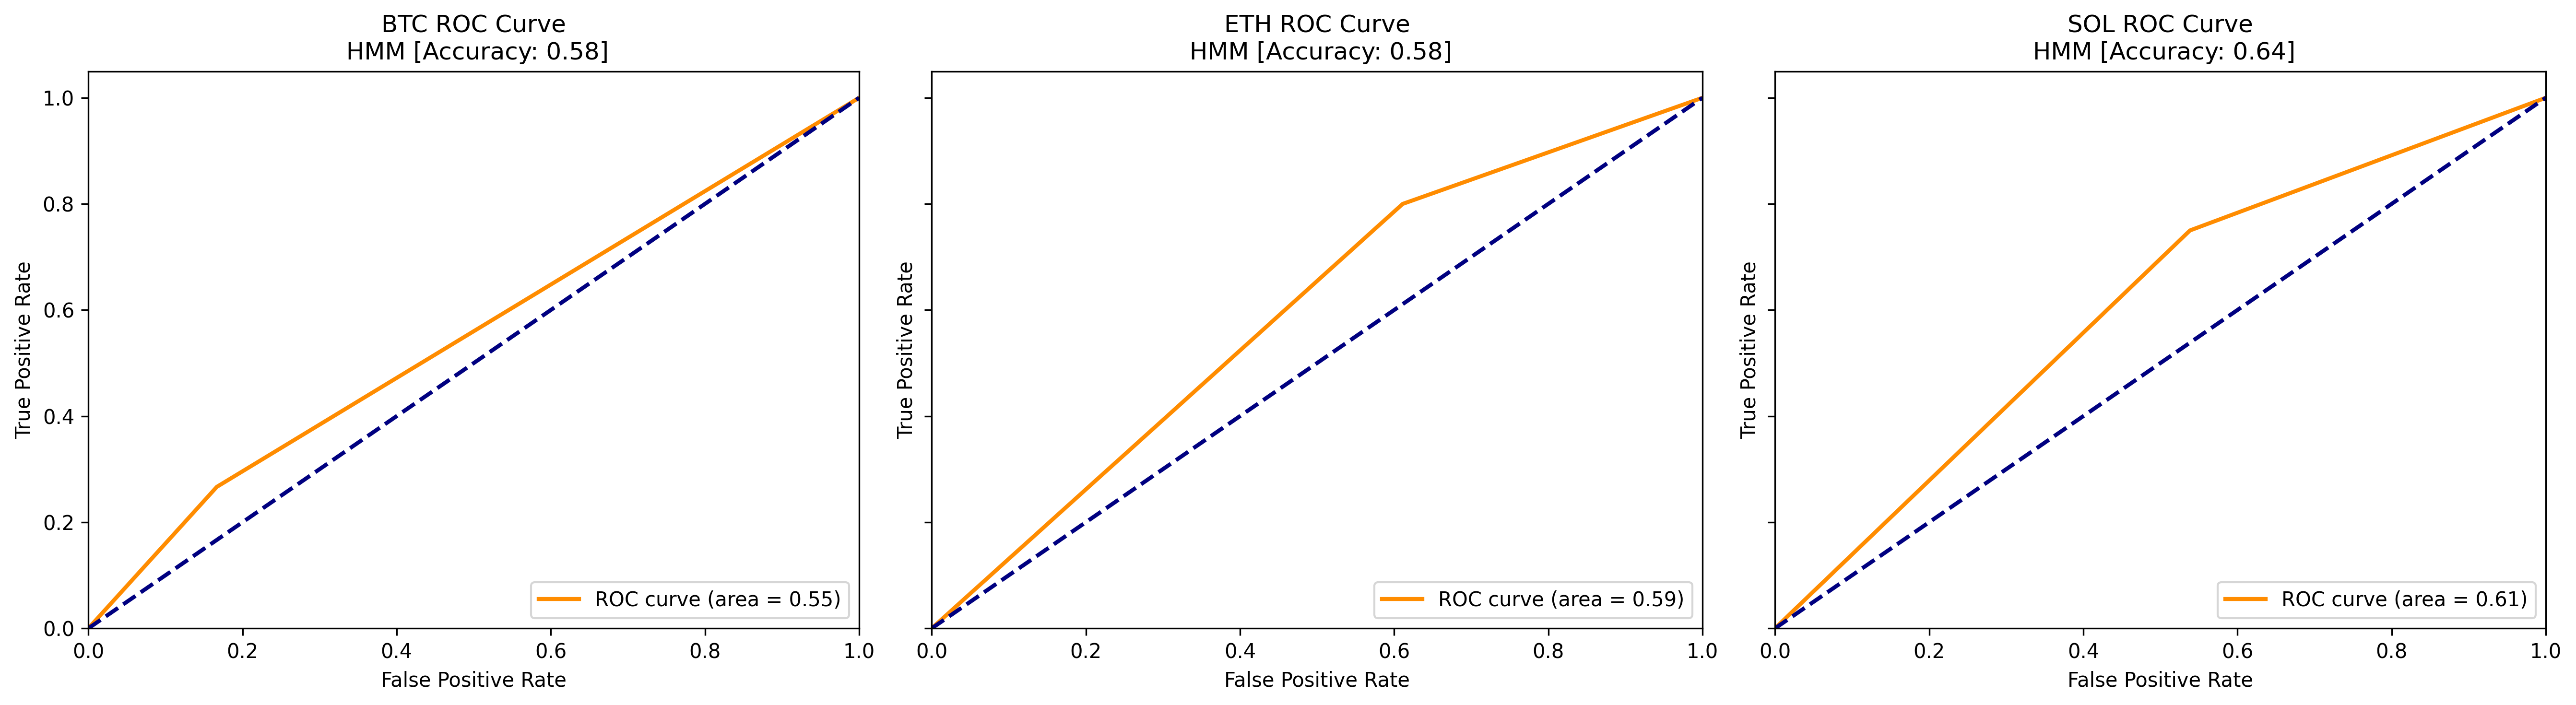

In [156]:
# List of cryptocurrencies and their corresponding data
cryptos = [
    ('BTC', btc_y_test, btc_hmm_pred, 'HMM'),
    ('ETH', eth_y_test, eth_hmm_pred, 'HMM'),
    ('SOL', sol_y_test, sol_hmm_pred, 'HMM')
]
# Create a figure with subplots for each cryptocurrency
n_cryptos = len(cryptos)
fig, axes = plt.subplots(1, n_cryptos, figsize=(6*n_cryptos, 5), dpi=300, sharey=True)

# Loop through the cryptocurrencies and plot their ROC curves
for (crypto_name, y_test, rf_pred, model_name), ax in zip(cryptos, axes):
    plot_roc_curve(y_test, rf_pred, crypto_name, model_name, ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [169]:
evaluation

,Model,Accuracy,Precision,Recall,F1 Score,Specificity,False Positive Rate,False Negative Rate
BTC_RF_60_10_5,Random Forest,0.545455,0.500000,0.800000,0.615385,0.333333,0.666667,0.200000
ETH_RF_60_10_5,Random Forest,0.575758,0.523810,0.733333,0.611111,0.444444,0.555556,0.266667
SOL_RF_60_10_5,Random Forest,0.575758,0.687500,0.550000,0.611111,0.615385,0.384615,0.450000
BTC_RF_C_8__kernal_sigmoid_gamme_auto,SVM,0.575758,0.526316,0.666667,0.588235,0.500000,0.500000,0.333333
ETH_RF_C_5__kernal_sigmoid_gamme_auto,SVM,0.636364,0.600000,0.600000,0.600000,0.666667,0.333333,0.400000
SOL_RF_C_4__kernal_sigmoid_gamme_auto,SVM,0.636364,0.750000,0.600000,0.666667,0.692308,0.307692,0.400000
BTC_XGB_2,XGBoost,0.575758,0.533333,0.533333,0.533333,0.611111,0.388889,0.466667
ETH_XGB_2,XGBoost,0.545455,0.500000,0.666667,0.571429,0.444444,0.555556,0.333333
SOL_XGB_2,XGBoost,0.757576,0.928571,0.650000,0.764706,0.923077,0.076923,0.350000
BTC_HMM_5,HMM,0.575758,0.571429,0.266667,0.363636,0.833333,0.166667,0.733333


#### Model 4: Long Short Term Memory (LSTM)

In [208]:
btc_lstm, eth_lstm, sol_lstm = btc.copy(), eth.copy(), sol.copy()

# Get all column names
columns_btc, columns_eth, columns_sol = btc_lstm.drop(columns='Indicator').columns.tolist(), eth_lstm.drop(columns='Indicator').columns.tolist(), sol_lstm.drop(columns='Indicator').columns.tolist()

# Normalize the feature columns
scaler_btc, scaler_eth, scaler_sol = MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
btc_lstm[columns_btc], eth_lstm[columns_eth], sol_lstm[columns_sol] = scaler_btc.fit_transform(btc_lstm[columns_btc]), scaler_eth.fit_transform(eth_lstm[columns_eth]), scaler_sol.fit_transform(sol_lstm[columns_sol])

def create_sequences(data, target, past_days, step=1):

    if len(data) != len(target):
        raise ValueError("Data and target must have the same length")
    
    if past_days >= len(data):
        raise ValueError("past_days must be less than the length of data")

    # Ensure target is 2D
    if target.ndim == 1:
        target = target.reshape(-1, 1)

    sequences = []
    labels = []

    for i in range(0, len(data) - past_days + 1, step):
        sequences.append(data[i:i+past_days])
        labels.append(target[i+past_days-1])

    return np.array(sequences), np.array(labels)

btc_X, eth_X, sol_X = btc_lstm[columns_btc].values, eth_lstm[columns_eth].values, sol_lstm[columns_sol].values
btc_y, eth_y, sol_y = btc_lstm['Indicator'].values, eth_lstm['Indicator'].values, sol_lstm['Indicator'].values

past_days = 4
btc_X, btc_y = create_sequences(btc_X, btc_y, past_days)
eth_X, eth_y = create_sequences(eth_X, eth_y, past_days)
sol_X, sol_y = create_sequences(sol_X, sol_y, past_days)

# Split the data for each cryptocurrency
def split_data(X, y, test_size=0.2):
    split_index = int(len(X) * (1 - test_size))
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:]

btc_X_train, btc_X_test, btc_y_train, btc_y_test = split_data(btc_X, btc_y)
eth_X_train, eth_X_test, eth_y_train, eth_y_test = split_data(eth_X, eth_y)
sol_X_train, sol_X_test, sol_y_train, sol_y_test = split_data(sol_X, sol_y)

btc_X_train, btc_X_test, btc_y_train, btc_y_test = btc_X_train.reshape((btc_X_train.shape[0], btc_X_train.shape[1], len(columns_btc))), btc_X_test.reshape((btc_X_test.shape[0], btc_X_test.shape[1], len(columns_btc))), btc_y_train, btc_y_test
eth_X_train, eth_X_test, eth_y_train, eth_y_test = eth_X_train.reshape((eth_X_train.shape[0], eth_X_train.shape[1], len(columns_eth))), eth_X_test.reshape((eth_X_test.shape[0], eth_X_test.shape[1], len(columns_eth))), eth_y_train, eth_y_test
sol_X_train, sol_X_test, sol_y_train, sol_y_test = sol_X_train.reshape((sol_X_train.shape[0], sol_X_train.shape[1], len(columns_sol))), sol_X_test.reshape((sol_X_test.shape[0], sol_X_test.shape[1], len(columns_sol))), sol_y_train, sol_y_test

In [223]:
from keras.metrics import Recall

# Build the LSTM model
# Define a function to create a new LSTM model
def create_model(input_shape):
    model = Sequential()

    model.add(LSTM(80, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    #model.add(LSTM(40, return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(LSTM(60, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(40))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    return model

# Assuming 'past_days' and 'columns' are defined elsewhere
input_shape = (past_days, len(columns_btc))

# Create a model for each cryptocurrency
model_btc = create_model(input_shape)
model_eth = create_model(input_shape)
model_sol = create_model(input_shape)

# Now each model can be compiled and trained with its respective dataset
model_btc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_eth.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_sol.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [224]:
# Fit the models
model_btc.fit(btc_X_train, btc_y_train, epochs=20, batch_size=5, validation_data=(btc_X_test, btc_y_test))
model_eth.fit(eth_X_train, eth_y_train, epochs=20, batch_size=5, validation_data=(eth_X_test, eth_y_test))
model_sol.fit(sol_X_train, sol_y_train, epochs=20, batch_size=5, validation_data=(sol_X_test, sol_y_test))

Epoch 1/20
26/26 [==============================] - 4s 37ms/step - loss: 0.6954 - accuracy: 0.4884 - val_loss: 0.6966 - val_accuracy: 0.4545
Epoch 2/20
26/26 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5504 - val_loss: 0.7011 - val_accuracy: 0.4545
Epoch 3/20
26/26 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.5504 - val_loss: 0.7039 - val_accuracy: 0.4545
Epoch 4/20
26/26 [==============================] - 0s 6ms/step - loss: 0.6891 - accuracy: 0.5349 - val_loss: 0.7190 - val_accuracy: 0.4545
Epoch 5/20
26/26 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.5504 - val_loss: 0.7366 - val_accuracy: 0.4545
Epoch 6/20
26/26 [==============================] - 0s 7ms/step - loss: 0.6730 - accuracy: 0.5504 - val_loss: 0.7755 - val_accuracy: 0.5152
Epoch 7/20
26/26 [==============================] - 0s 6ms/step - loss: 0.6713 - accuracy: 0.5349 - val_loss: 0.8129 - val_accuracy: 0.4848
Epoch 8/20
26/26 [=

In [225]:
def evaluate_and_predict(model, X_test, y_test, name, evaluation_df=evaluation):
    # Evaluate the model
    accuracy = model.evaluate(X_test, y_test)

    
    # Make predictions
    predictions = model.predict(X_test)
    # Convert probabilities to binary predictions based on a 0.5 threshold
    binary_predictions = (predictions > 0.5).astype(int)

    #print('\n\nPredicted vs Actual from the model:')
    #print('')
    # Display the first 10 predictions and actual values
    #for i in range(10):
        #print(f'Predicted: {binary_predictions[i][0]}, Actual: {y_test[i]}')

    conf_matrix = confusion_matrix(y_test, binary_predictions)
    class_report = classification_report(y_test, binary_predictions)

        # Evaluate the model
    accuracy = accuracy_score(y_test, binary_predictions)
    conf_matrix = confusion_matrix(y_test, binary_predictions)
    class_report = classification_report(y_test, binary_predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    f1 = f1_score(y_test, binary_predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, binary_predictions).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Calculate false positive rate
    false_positive_rate = fp / (fp + tn)
    # Calculate false negative rate
    false_negative_rate = fn / (fn + tp)
    
    # Print results
    print(f"\nAccuracy: {accuracy}")
    print(f'Test F1_Score: {f1}')
    print(f'Test Recall: {recall}')
    print('')
    print("Confusion Matrix:")
    print(conf_matrix)

   # Update or initialize the evaluation dataframe   # Update or initialize the evaluation dataframe
    if evaluation_df is not None:
        model_key = f"{name}_LSTM"
        evaluation_df.loc[model_key] = ['LSTM', accuracy, precision, recall, f1, specificity, false_positive_rate, false_negative_rate]

    print('')
    print('')
    print("Classification Report:")
    print(class_report)

    return binary_predictions

# Assuming btc_X_test, btc_y_test, etc. are already defined and prepared for each model

print("Evaluating BTC Model: \n")
print("Evaluating BTC Model: \n")
print("-------------------- \n")
btc_lstm_pred = evaluate_and_predict(model_btc, btc_X_test, btc_y_test, 'BTC')

print("\n \nEvaluating ETH Model:\n")
print("Evaluating ETH Model: \n")
print("-------------------- \n")
eth_lstm_pred = evaluate_and_predict(model_eth, eth_X_test, eth_y_test, 'ETH')

print("\n \nEvaluating SOL Model:\n")
print("Evaluating SOL Model: \n")
print("-------------------- \n")
sol_lstm_pred = evaluate_and_predict(model_sol, sol_X_test, sol_y_test, 'SOL')

Evaluating BTC Model: 

Evaluating BTC Model: 

-------------------- 

2/2 [==============================] - 2s 3ms/step

Accuracy: 0.5151515151515151
Test F1_Score: 0.6
Test Recall: 0.8

Confusion Matrix:
[[ 5 13]
 [ 3 12]]


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.28      0.38        18
           1       0.48      0.80      0.60        15

    accuracy                           0.52        33
   macro avg       0.55      0.54      0.49        33
weighted avg       0.56      0.52      0.48        33


 
Evaluating ETH Model:

Evaluating ETH Model: 

-------------------- 

2/2 [==============================] - 1s 3ms/step

Accuracy: 0.5151515151515151
Test F1_Score: 0.6190476190476191
Test Recall: 0.8666666666666667

Confusion Matrix:
[[ 4 14]
 [ 2 13]]


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.22      0.33        18
           1       0.48      0

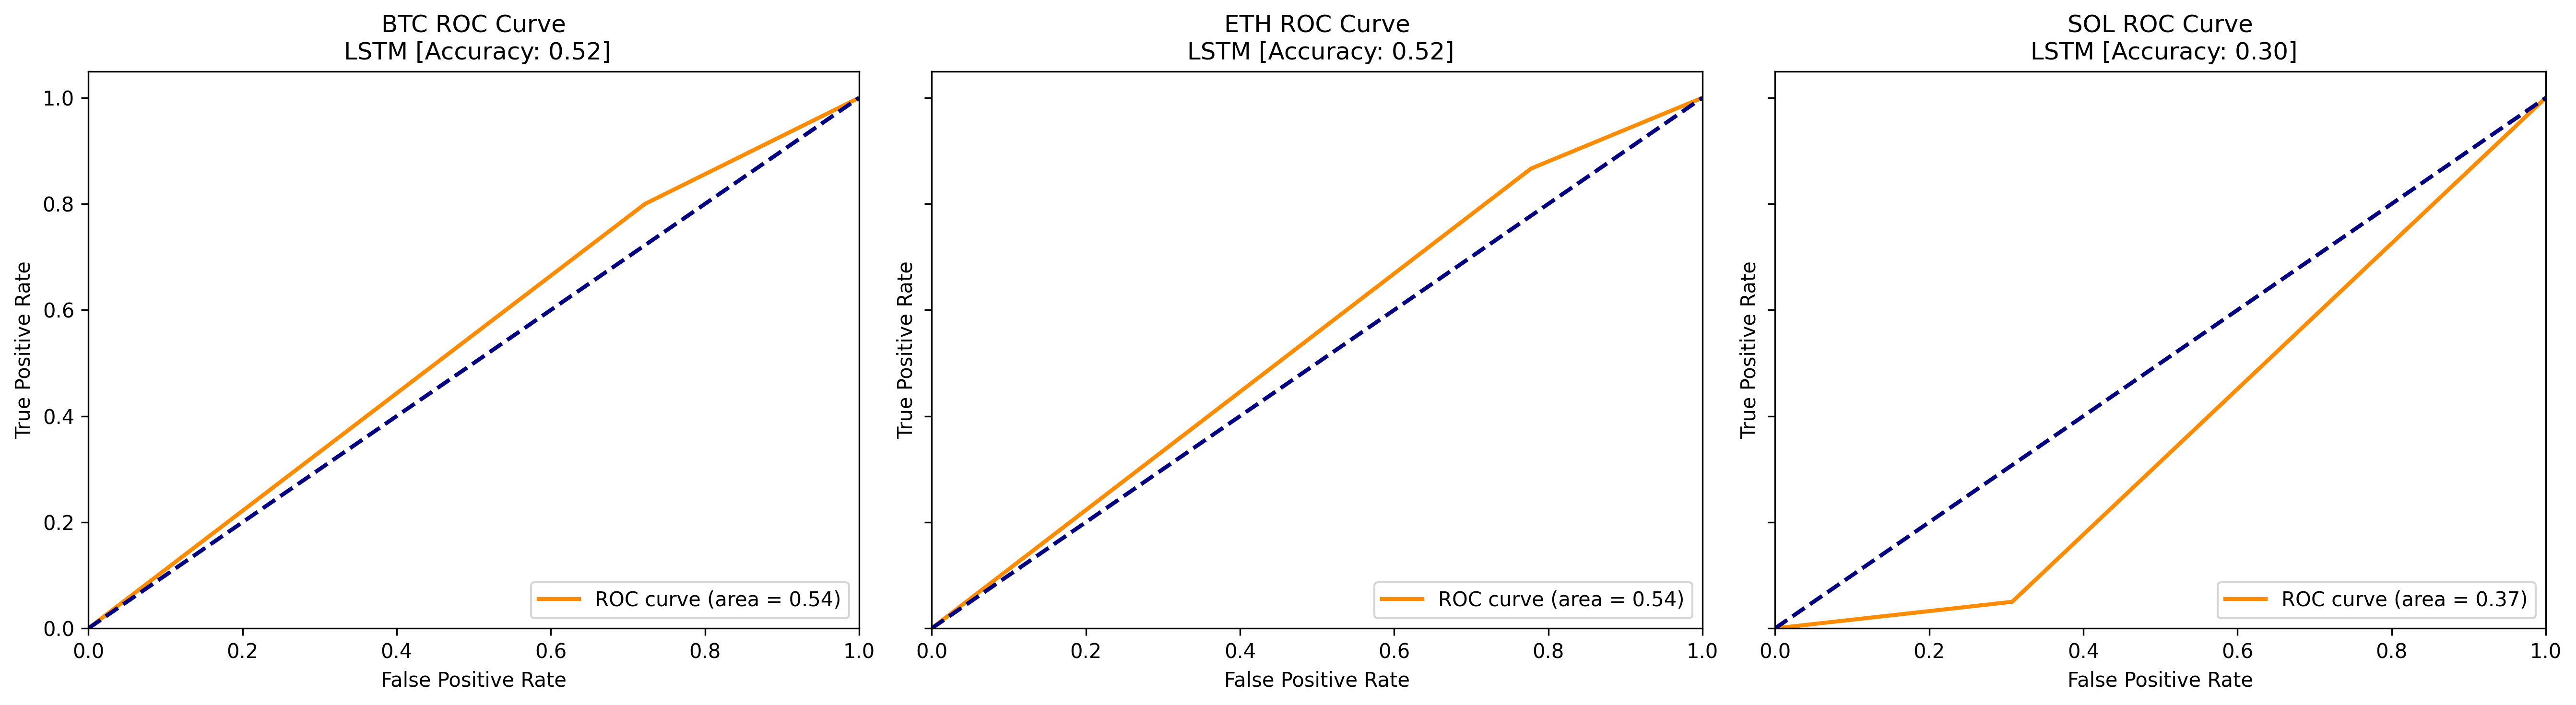

In [226]:
# List of cryptocurrencies and their corresponding data
cryptos = [
    ('BTC', btc_y_test, btc_lstm_pred, 'LSTM'),
    ('ETH', eth_y_test, eth_lstm_pred, 'LSTM'),
    ('SOL', sol_y_test, sol_lstm_pred, 'LSTM'),
]
# Create a figure with subplots for each cryptocurrency
n_cryptos = len(cryptos)
fig, axes = plt.subplots(1, n_cryptos, figsize=(6*n_cryptos, 5), dpi=300, sharey=True)

# Loop through the cryptocurrencies and plot their ROC curves
for (crypto_name, y_test, btc_xgb_pred, model_name), ax in zip(cryptos, axes):
    plot_roc_curve(y_test, btc_xgb_pred, crypto_name, model_name, ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [228]:
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import numpy as np

# Function to get the gradients of the model's output with respect to the input
def get_saliency_map(model, input_data, target_index):
    input_data = tf.convert_to_tensor(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        prediction = model(input_data)
        loss = prediction[:, target_index]
    gradient = tape.gradient(loss, input_data)
    return gradient

# Get a single input sample to compute the saliency map
input_sample = X_test[7:8]

# Compute the saliency map for the sample
saliency_map = get_saliency_map(model, input_sample, 0).numpy().squeeze()


In [229]:
saliency = pd.DataFrame(saliency_map, columns=columns)
saliency = saliency.transpose()
saliency = saliency.sort_values(by=0, ascending=False)
saliency = saliency[:5]

# Plot each row as a separate line chart
plt.figure(figsize=(16, 6))
for row in saliency.index:
    plt.plot(saliency.columns, saliency.loc[row], marker='o', label=row)
plt.title('Saliency Map Top 5 Features')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Metrics')
plt.grid(True)
plt.show()

,0,1,2,3,4
RSI_td,0.104099,0.057220,0.028502,0.010478,0.002489
Oil_Volume,0.096293,0.054619,0.029254,0.010547,0.002512
3MA_td,0.081180,0.045811,0.025831,0.009606,0.002387
MACD_td,0.070218,0.040360,0.019133,0.006005,0.001214
Total_Gtrends,0.062978,0.033709,0.016309,0.005976,0.001398


In [227]:
evaluation

,Model,Accuracy,Precision,Recall,F1 Score,Specificity,False Positive Rate,False Negative Rate
BTC_RF_60_10_5,Random Forest,0.606061,0.550000,0.733333,0.628571,0.500000,0.500000,0.266667
ETH_RF_60_10_5,Random Forest,0.545455,0.500000,0.733333,0.594595,0.388889,0.611111,0.266667
SOL_RF_60_10_5,Random Forest,0.666667,0.846154,0.550000,0.666667,0.846154,0.153846,0.450000
BTC_RF_C_8__kernal_sigmoid_gamme_auto,SVM,0.575758,0.526316,0.666667,0.588235,0.500000,0.500000,0.333333
ETH_RF_C_5__kernal_sigmoid_gamme_auto,SVM,0.636364,0.600000,0.600000,0.600000,0.666667,0.333333,0.400000
SOL_RF_C_4__kernal_sigmoid_gamme_auto,SVM,0.636364,0.750000,0.600000,0.666667,0.692308,0.307692,0.400000
BTC_XGB_2,XGBoost,0.575758,0.533333,0.533333,0.533333,0.611111,0.388889,0.466667
ETH_XGB_2,XGBoost,0.545455,0.500000,0.666667,0.571429,0.444444,0.555556,0.333333
SOL_XGB_2,XGBoost,0.757576,0.928571,0.650000,0.764706,0.923077,0.076923,0.350000
BTC_HMM_5,HMM,0.575758,0.571429,0.266667,0.363636,0.833333,0.166667,0.733333


### Aggregations

In [198]:
# Flatten the predictions if needed
btc_xgb_pred = btc_xgb_pred.flatten()
btc_lstm_pred = btc_lstm_pred.flatten()

eth_xgb_pred = eth_xgb_pred.flatten()
eth_lstm_pred = eth_lstm_pred.flatten()

sol_xgb_pred = sol_xgb_pred.flatten()
sol_lstm_pred = sol_lstm_pred.flatten()

# Stack the predictions for each asset
btc_stacked_predictions = np.vstack([btc_rf_pred, btc_svm_pred, btc_xgb_pred, btc_hmm_pred])
eth_stacked_predictions = np.vstack([eth_rf_pred, eth_svm_pred, eth_xgb_pred, eth_hmm_pred])
sol_stacked_predictions = np.vstack([sol_rf_pred, sol_svm_pred, sol_xgb_pred, sol_hmm_pred])

# Average the predictions
btc_average_predictions = np.mean(btc_stacked_predictions, axis=0)
eth_average_predictions = np.mean(eth_stacked_predictions, axis=0)
sol_average_predictions = np.mean(sol_stacked_predictions, axis=0)

# Convert average predictions to binary (0 or 1)
btc_ensemble_predictions = (btc_average_predictions > 0.5).astype(int)
eth_ensemble_predictions = (eth_average_predictions > 0.5).astype(int)
sol_ensemble_predictions = (sol_average_predictions > 0.5).astype(int)




In [200]:
# Evaluate the models
def evaluate_ensemble(y_test, predictions, name):
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Calculate false positive rate
    false_positive_rate = fp / (fp + tn)
    # Calculate false negative rate
    false_negative_rate = fn / (fn + tp)

    print(f"\n{name} Ensemble Model Evaluation:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

# Assuming y_test variables for BTC, ETH, and SOL are named appropriately
evaluate_ensemble(btc_y_test, btc_ensemble_predictions, 'BTC')
evaluate_ensemble(eth_y_test, eth_ensemble_predictions, 'ETH')
evaluate_ensemble(sol_y_test, sol_ensemble_predictions, 'SOL')


BTC Ensemble Model Evaluation:
Accuracy: 0.6060606060606061
Confusion Matrix:
[[16  2]
 [11  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.89      0.71        18
           1       0.67      0.27      0.38        15

    accuracy                           0.61        33
   macro avg       0.63      0.58      0.55        33
weighted avg       0.63      0.61      0.56        33



ValueError: Found input variables with inconsistent numbers of samples: [34, 33]

In [202]:
print(btc_rf_pred)
print(btc_svm_pred)
print(btc_xgb_pred)
print(btc_hmm_pred)
print(btc_lstm_pred)

[1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0]
[1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0]
[0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0]


In [409]:
evaluation

,Model,Accuracy,Precision,Recall,F1
BTC_HMM_5,HMM,0.53125,0.250000,0.076923,0.117647
ETH_HMM_5,HMM,0.56250,0.517241,1.000000,0.681818
SOL_HMM_5,HMM,0.56250,0.625000,0.555556,0.588235
BTC_XGB_2,XGBoost,0.59375,0.500000,0.538462,0.518519
ETH_XGB_2,XGBoost,0.53125,0.500000,0.400000,0.444444
SOL_XGB_2,XGBoost,0.53125,0.578947,0.611111,0.594595
BTC_RF_C_7__kernal_sigmoid_gamme_auto,SVM,0.56250,0.478261,0.846154,0.611111
ETH_RF_C_7__kernal_sigmoid_gamme_auto,SVM,0.56250,0.538462,0.466667,0.500000
SOL_RF_C_7__kernal_sigmoid_gamme_auto,SVM,0.68750,0.785714,0.611111,0.687500
BTC_RF_60_10_5,Random Forest,0.53125,0.464286,1.000000,0.634146


In [206]:
btc_ensemble_predictions
def train_evaluate_ensemble(prediction, name, evaluation_df=evaluation):

    # Evaluate the model
    accuracy = accuracy_score(y_test, prediction)
    conf_matrix = confusion_matrix(y_test, prediction)
    class_report = classification_report(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Calculate false positive rate
    false_positive_rate = fp / (fp + tn)
    # Calculate false negative rate
    false_negative_rate = fn / (fn + tp)
    
    
    # Print results
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Update or initialize the evaluation dataframe
    if evaluation_df is not None:
        model_key = f"{name}_ENSEMBLE"
        evaluation_df.loc[model_key] = ['Ensemble', accuracy, precision, recall, f1, specificity, false_positive_rate, false_negative_rate]


train_evaluate_ensemble(btc_ensemble_predictions, 'BTC')
train_evaluate_ensemble(eth_ensemble_predictions, 'ETH')
train_evaluate_ensemble(sol_ensemble_predictions, 'SOL')


Accuracy: 0.5151515151515151
Confusion Matrix:
[[12  1]
 [15  5]]
Accuracy: 0.6060606060606061
Confusion Matrix:
[[ 9  4]
 [ 9 11]]
Accuracy: 0.6666666666666666
Confusion Matrix:
[[12  1]
 [10 10]]


In [207]:
evaluation

,Model,Accuracy,Precision,Recall,F1 Score,Specificity,False Positive Rate,False Negative Rate
BTC_RF_60_10_5,Random Forest,0.606061,0.550000,0.733333,0.628571,0.500000,0.500000,0.266667
ETH_RF_60_10_5,Random Forest,0.545455,0.500000,0.733333,0.594595,0.388889,0.611111,0.266667
SOL_RF_60_10_5,Random Forest,0.666667,0.846154,0.550000,0.666667,0.846154,0.153846,0.450000
BTC_RF_C_8__kernal_sigmoid_gamme_auto,SVM,0.575758,0.526316,0.666667,0.588235,0.500000,0.500000,0.333333
ETH_RF_C_5__kernal_sigmoid_gamme_auto,SVM,0.636364,0.600000,0.600000,0.600000,0.666667,0.333333,0.400000
SOL_RF_C_4__kernal_sigmoid_gamme_auto,SVM,0.636364,0.750000,0.600000,0.666667,0.692308,0.307692,0.400000
BTC_XGB_2,XGBoost,0.575758,0.533333,0.533333,0.533333,0.611111,0.388889,0.466667
ETH_XGB_2,XGBoost,0.545455,0.500000,0.666667,0.571429,0.444444,0.555556,0.333333
SOL_XGB_2,XGBoost,0.757576,0.928571,0.650000,0.764706,0.923077,0.076923,0.350000
BTC_HMM_5,HMM,0.575758,0.571429,0.266667,0.363636,0.833333,0.166667,0.733333


In [188]:
print(eth_rf_pred)
print(eth_svm_pred)
print(eth_xgb_pred)
print(eth_hmm_pred)
print(eth_lstm_pred)

[1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1]
[1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0]
[1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1]
[1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1]


In [162]:
#btc_rf_pred
#btc_svm_pred
#btc_xgb_pred = btc_xgb_pred.flatten()
#btc_xgb_pred
#btc_hmm_pred = np.array(btc_hmm_pred)
#btc_lstm_pred = btc_lstm_pred.flatten()
#btc_lstm_pred
btc_hmm_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

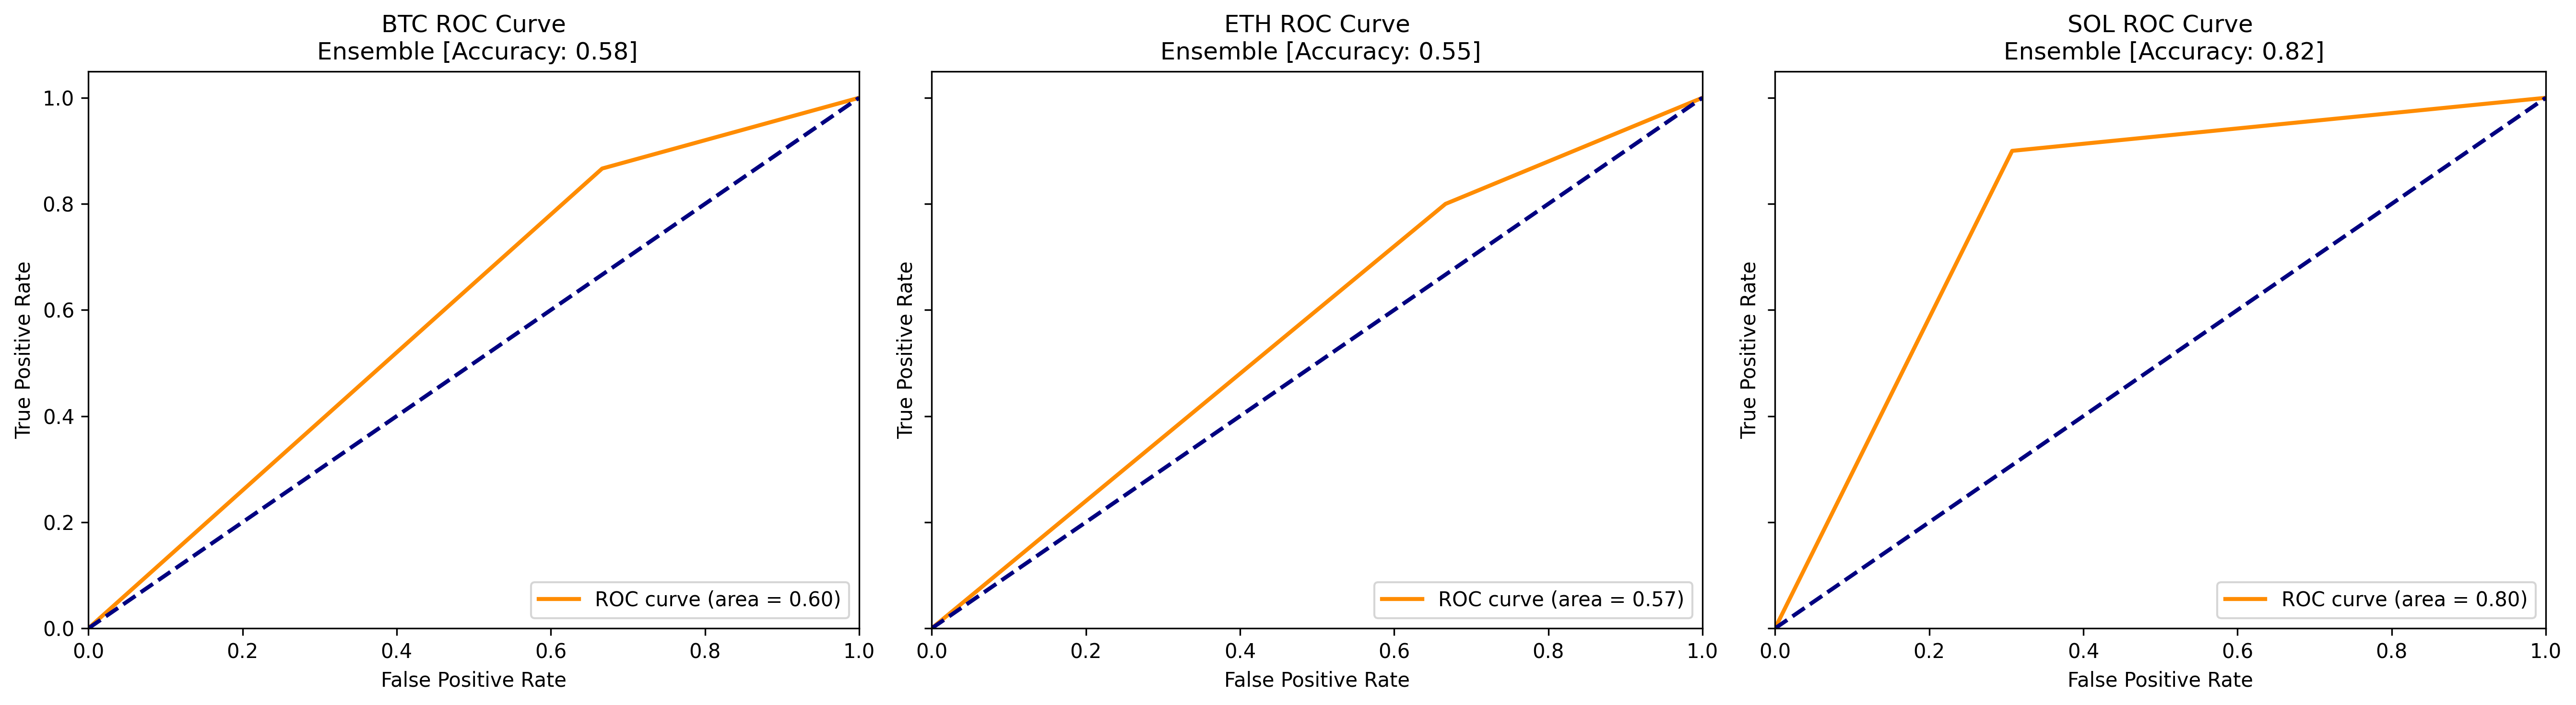

In [121]:
# List of cryptocurrencies and their corresponding data
cryptos = [
    ('BTC', btc_y_test, btc_ensemble_predictions, 'Ensemble'),
    ('ETH', eth_y_test, eth_ensemble_predictions, 'Ensemble'),
    ('SOL', sol_y_test, sol_ensemble_predictions, 'Ensemble'),
]
# Create a figure with subplots for each cryptocurrency
n_cryptos = len(cryptos)
fig, axes = plt.subplots(1, n_cryptos, figsize=(6*n_cryptos, 5), dpi=300, sharey=True)

# Loop through the cryptocurrencies and plot their ROC curves
for (crypto_name, y_test, btc_xgb_pred, model_name), ax in zip(cryptos, axes):
    plot_roc_curve(y_test, btc_xgb_pred, crypto_name, model_name, ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [232]:
evaluation['Currency'] = evaluation.index
evaluation['Currency'] = evaluation['Currency'].apply(lambda x: x[:3])
evaluation


baba = evaluation.copy()

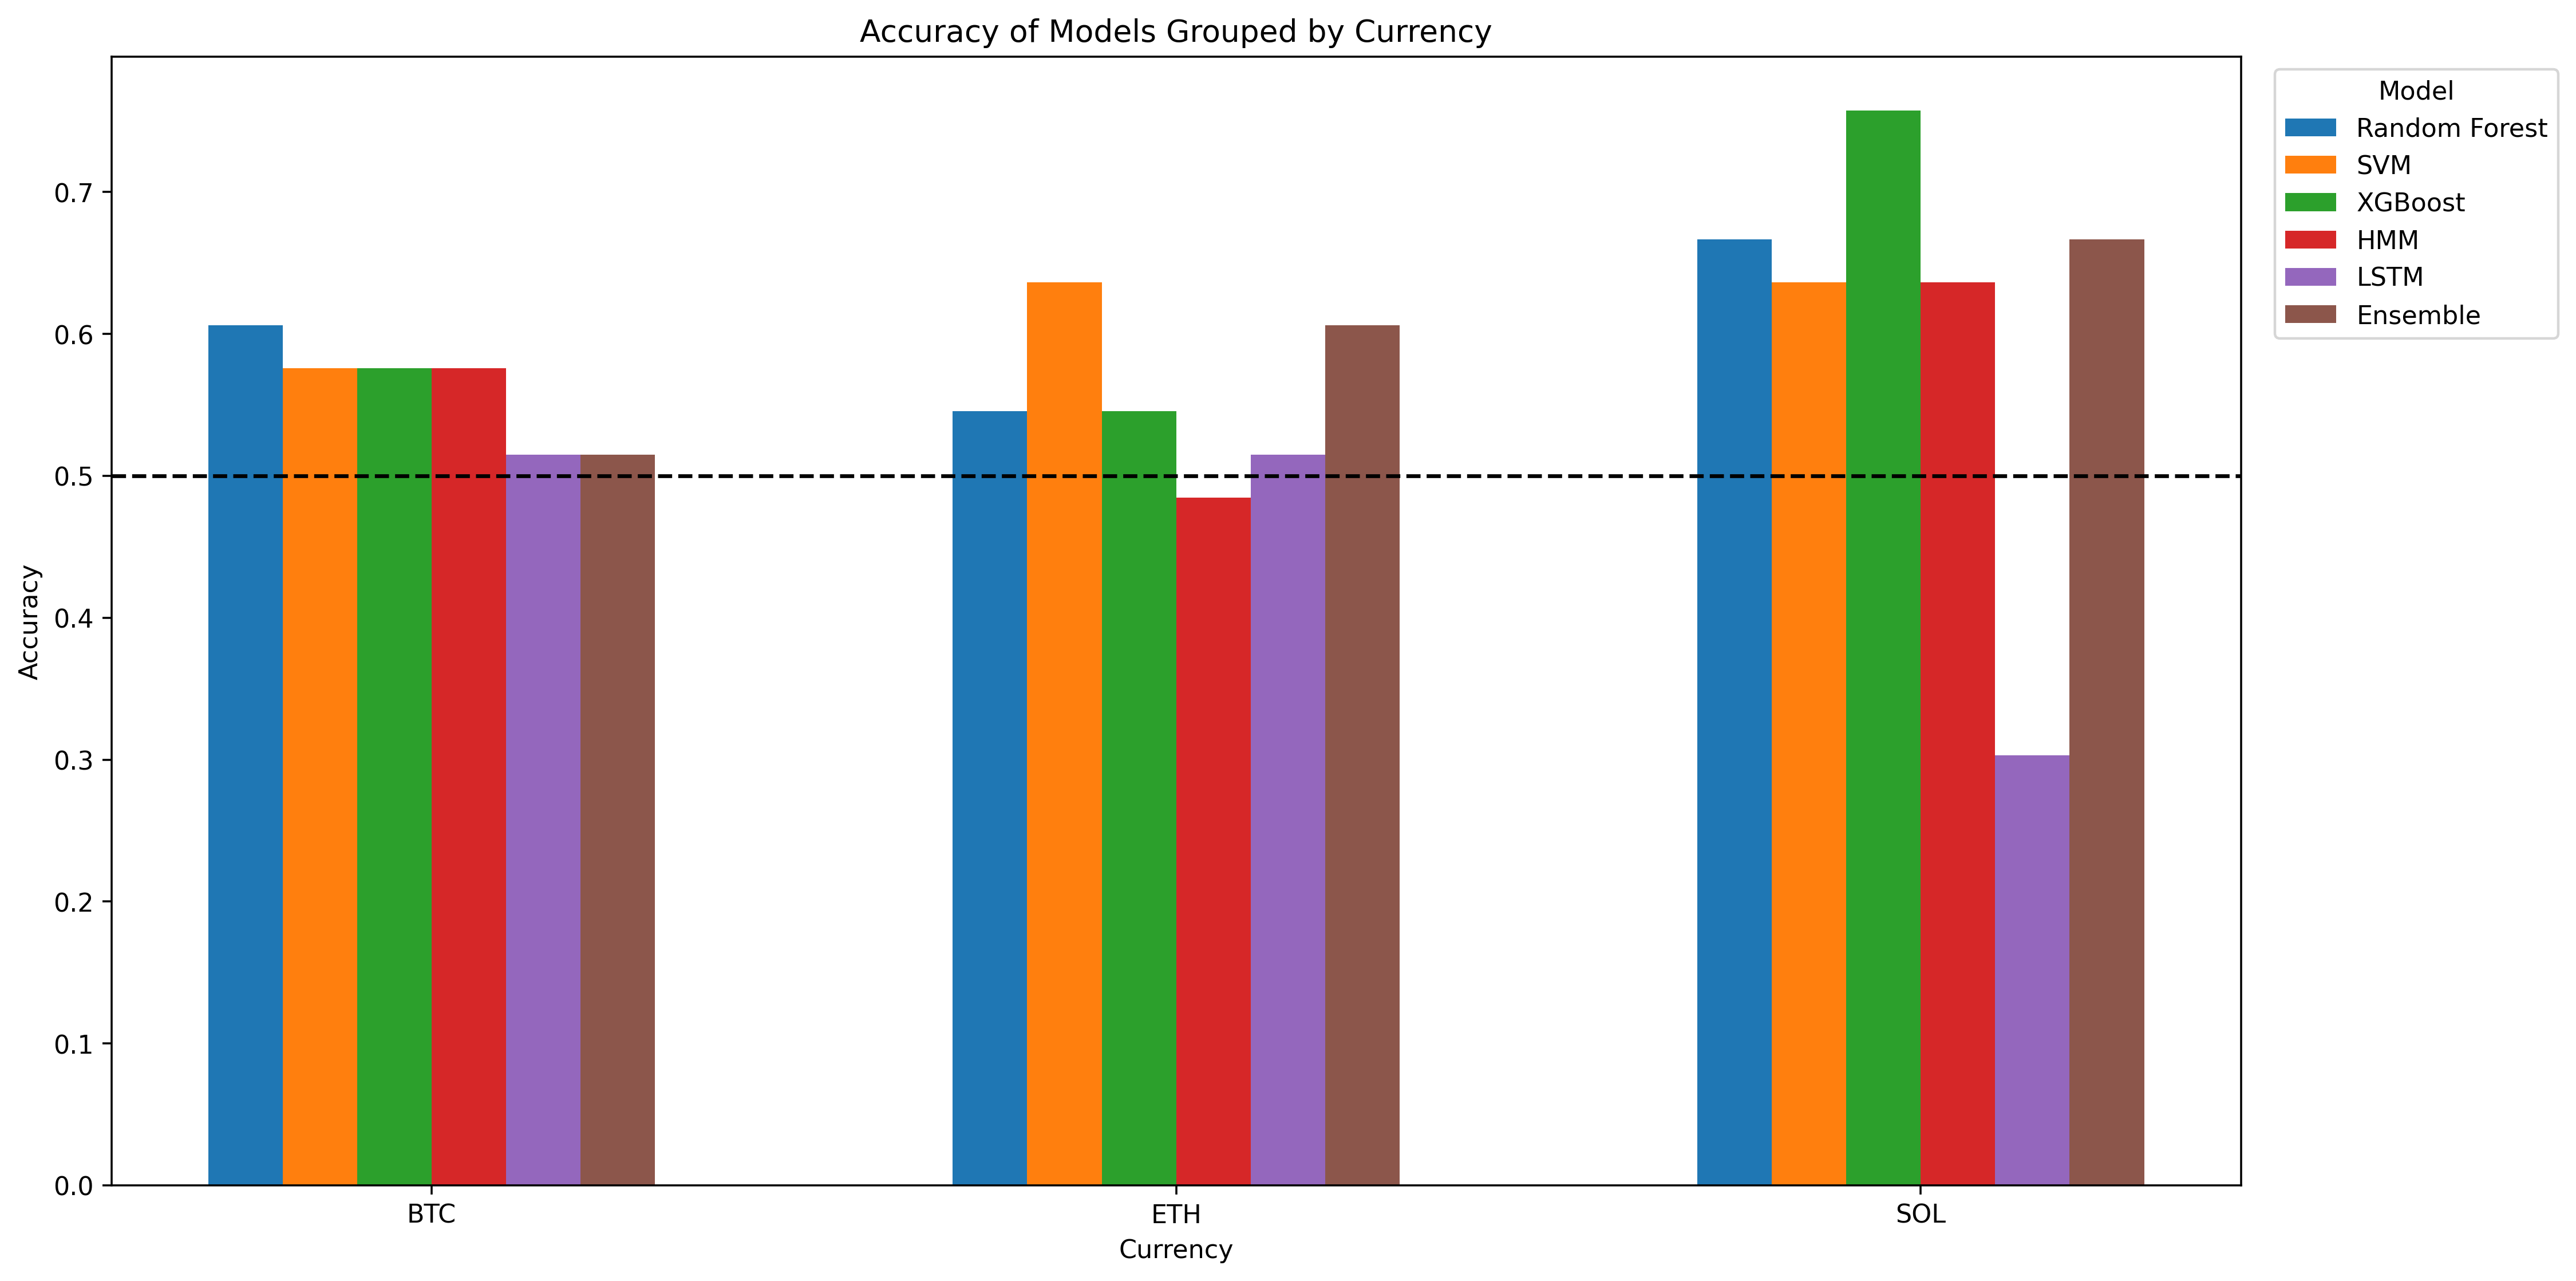

In [253]:
# Extract unique currencies and models
currencies = baba['Currency'].unique()
models = baba['Model'].unique()
num_currencies = len(currencies)
num_models = len(models)

# Set up bar plot parameters
bar_width = 0.1
index = np.arange(num_currencies)

# Create a figure and axis
plt.figure(figsize=(15, 8), dpi=320)

# Plot each model's data
for i, model in enumerate(models):
    model_data = baba[baba['Model'] == model]
    plt.bar(index + i * bar_width, model_data['Accuracy'], bar_width, label=model)

# Adding labels and title
plt.xlabel('Currency')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models Grouped by Currency')
plt.xticks(index + bar_width * (num_models / 2 - 0.5), currencies)
plt.axhline(0.5, linestyle='dashed', color='black')
plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')

# Show the plot
plt.show()